<a href="https://colab.research.google.com/github/patrick013/Object-Detection---Yolov3/blob/master/Object_Detection_Yolo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Object Detection with Yolov3


![cover](https://bitmovin.com/wp-content/uploads/2019/08/Object_detection_Blog_Image_Q3_19.jpg)

Object detection is a computer vision task that involves both localizing one or more objects within an image and classifying each object in the image.

It is a challenging computer vision task that requires both successful object localization in order to locate and draw a bounding box around each object in an image, and object classification to predict the correct class of object that was localized.
Yolo is a faster object detection algorithm in computer vision and first described by Joseph Redmon, Santosh Divvala, Ross Girshick and Ali Farhadi in ['You Only Look Once: Unified, Real-Time Object Detection'](https://arxiv.org/abs/1506.02640)

This notebook implements an object detection based on a pre-trained model - [YOLOv3 Pre-trained Weights (yolov3.weights) (237 MB)](https://pjreddie.com/media/files/yolov3.weights).  The model architecture is called a “DarkNet” and was originally loosely based on the VGG-16 model. 



## Load Pretrained Model

In [1]:
import struct
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import ZeroPadding2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import add, concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import load_img
import matplotlib.pyplot as plt
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from numpy import expand_dims

In [2]:
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader(r"./model/yolov3.weights")
# set the model weights into the model
weight_reader.load_weights(model)
# # save the model to file
# model.save('/content/drive/My Drive/DPprojects/Object Detection - Yolo/model/model.h5')

NameError: name 'make_yolov3_model' is not defined

In [ ]:
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_0 (Conv2D)                 (None, None, None, 3 864         input_4[0][0]                    
__________________________________________________________________________________________________
bnorm_0 (BatchNormalization)    (None, None, None, 3 128         conv_0[0][0]                     
__________________________________________________________________________________________________
leaky_0 (LeakyReLU)             (None, None, None, 3 0           bnorm_0[0][0]                    
____________________________________________________________________________________________

## Make Preditions

In [ ]:
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]

In [ ]:
IMAGE_WIDTH=416
IMAGE_HEIGHT=416
def load_and_preprocess_image(path,shape):
  image=tf.io.read_file(path)
  width,height=load_img(path).size
  image=tf.image.decode_jpeg(image,channels=3)
  image=tf.image.resize(image, shape)
  image/=255
  return image,width,height

Image comes from (https://www.strathcona.ca/transportation-roads/traffic/traffic-signals/)

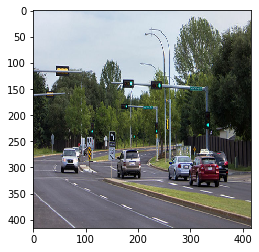

In [273]:
photo_filename='/content/drive/My Drive/DPprojects/Object Detection - Yolo/images/traffic.jpg'
_image, image_w, image_h=load_and_preprocess_image(photo_filename,[IMAGE_WIDTH,IMAGE_HEIGHT])
plt.imshow(_image)

In [274]:
image = expand_dims(_image, 0)
yhat = model.predict(image)
print([a.shape for a in yhat])

[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]


## Process output matrix

In [ ]:
# This cell is based on https://machinelearningmastery.com/how-to-perform-object-detection-with-yolov3-in-keras/
class BoundBox:
	'''
	Objects of boxes. (xmin,ymin) represents the upleft coordinate of the box while (xmax,ymax) means downright one.
	'''
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1
 
	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)
 
		return self.label
 
	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]
 
		return self.score

def _sigmoid(x):
	return 1. / (1. + np.exp(-x))
 
def decode_netout(netout, anchors, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			# if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

In [ ]:
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
boxes = list()
for i in range(len(yhat)):
	boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)

for i in range(len(boxes)):
	x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
	y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
	boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
	boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
	boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
	boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [277]:
len(boxes)

10647

## Boxes Filters

From the sections above, it is clear to see that there are over ten thousands of boxes detected. This next step is to filter the boxes with very low confidence by using threshold.

In [ ]:
def box_filter(boxes,labels,threshold_socre):
	valid_boxes=[]
	valid_labels=[]
	valid_scores=[]
	for box in boxes:
		for i in range(len(labels)):
			if box.classes[i] > threshold_socre:
				valid_boxes.append(box)
				valid_labels.append(labels[i])
				valid_scores.append(box.classes[i])
		
	return (valid_boxes,valid_labels,valid_scores)

In [ ]:
valid_data= box_filter(boxes, labels, threshold_socre=0.6)

## Draw all the boxes

In [ ]:
def draw_boxes(filename, valid_data):

	data = pyplot.imread(filename)
	pyplot.imshow(data)
	ax = pyplot.gca()
	for i in range(len(valid_data[0])):
		box = valid_data[0][i]
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		width, height = x2 - x1, y2 - y1
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		ax.add_patch(rect)
		print(valid_data[1][i], valid_data[2][i])
		label = "%s (%.3f)" % (valid_data[1][i], valid_data[2][i])
		pyplot.text(x1, y1, label, color='white')
	pyplot.show()

car 0.9799808
car 0.90150255
car 0.9822434
car 0.8228119
car 0.9342798
car 0.9315793
car 0.98184425
car 0.9982241
car 0.98154813
car 0.90509343
car 0.766863
car 0.98158306
car 0.92317057
car 0.6597396
car 0.9845723
car 0.98843795
car 0.88082886
traffic light 0.6188287
traffic light 0.75972
traffic light 0.70200646
traffic light 0.8713709
traffic light 0.964606
traffic light 0.77623147
traffic light 0.8328071
car 0.6020878
car 0.7852913


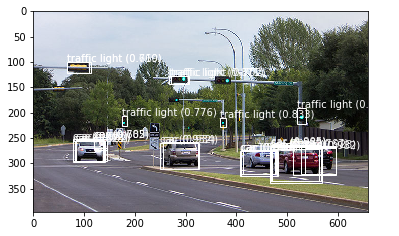

In [281]:
draw_boxes(photo_filename,valid_data)

## Non-max Seppression, NMS

In [ ]:
def encoder_dic(valid_data):
  data_dic={}
  (valid_boxes,valid_labels,valid_scores)=valid_data
  for box, label,score in zip(valid_boxes,valid_labels,valid_scores):
    if label not in data_dic:
      data_dic[label]=[[score,box,'kept']]
    else:
      data_dic[label].append([score,box,'kept'])
      
  return data_dic
dic=encoder_dic(valid_data)

In [ ]:
def decode_box_coor(box):
  return (box.xmin, box.ymin,box.xmax, box.ymax )

def iou(box1, box2):
  (box1_x1, box1_y1, box1_x2, box1_y2) = decode_box_coor(box1)
  (box2_x1, box2_y1, box2_x2, box2_y2) = decode_box_coor(box2)

  xi1 = max(box1_x1,box2_x1)
  yi1 = max(box1_y1,box2_y1)
  xi2 = min(box1_x2,box2_x2)
  yi2 = min(box1_y2,box2_y2)
  inter_width = xi2-xi1
  inter_height = yi2-yi1
  inter_area = max(inter_height,0)*max(inter_width,0)

  box1_area = (box1_x2-box1_x1)*(box1_y2-box1_y1)
  box2_area = (box2_x2-box2_x1)*(box2_y2-box2_y1)
  union_area = box1_area+box2_area-inter_area 

  iou = inter_area/union_area
  
  return iou

def do_nms(data_dic, nms_thresh):
  final_boxes,final_scores,final_labels=list(),list(),list()
  for label in data_dic:
    scores_boxes=sorted(data_dic[label],reverse=True)
    for i in range(len(scores_boxes)):
      if scores_boxes[i][2]=='removed': continue
      for j in range(i+1,len(scores_boxes)):
        if iou(scores_boxes[i][1],scores_boxes[j][1]) >= nms_thresh:
          scores_boxes[j][2]="removed"

    for e in scores_boxes:
      print(label+' '+str(e[0]) + " status: "+ e[2])
      if e[2]=='kept':
        final_boxes.append(e[1])
        final_labels.append(label)
        final_scores.append(e[0])
    

  return (final_boxes,final_labels,final_scores)

In [285]:
final_data=do_nms(dic, 0.7)

car 0.9982241 status: kept
car 0.98843795 status: kept
car 0.9845723 status: removed
car 0.9822434 status: kept
car 0.98184425 status: removed
car 0.98158306 status: kept
car 0.98154813 status: removed
car 0.9799808 status: removed
car 0.9342798 status: kept
car 0.9315793 status: removed
car 0.92317057 status: removed
car 0.90509343 status: removed
car 0.90150255 status: removed
car 0.88082886 status: removed
car 0.8228119 status: removed
car 0.7852913 status: kept
car 0.766863 status: kept
car 0.6597396 status: removed
car 0.6020878 status: removed
traffic light 0.964606 status: kept
traffic light 0.8713709 status: kept
traffic light 0.8328071 status: kept
traffic light 0.77623147 status: kept
traffic light 0.75972 status: kept
traffic light 0.70200646 status: removed
traffic light 0.6188287 status: removed


car 0.9982241
car 0.98843795
car 0.9822434
car 0.98158306
car 0.9342798
car 0.7852913
car 0.766863
traffic light 0.964606
traffic light 0.8713709
traffic light 0.8328071
traffic light 0.77623147
traffic light 0.75972


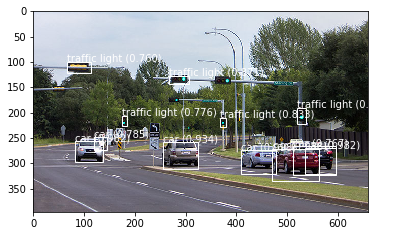

In [286]:
draw_boxes(photo_filename,final_data)

### Use Keras "non_max_suppression"

In [ ]:
def yolo_non_max_suppression(scores, boxes, classes, max_boxes = 10, iou_threshold = 0.5):
    
    max_boxes_tensor = K.variable(max_boxes, dtype='int32')     # tensor to be used in tf.image.non_max_suppression()
    K.get_session().run(tf.variables_initializer([max_boxes_tensor])) # initialize variable max_boxes_tensor
    nms_indices = tf.image.non_max_suppression(scores=scores,boxes=boxes,max_output_size=max_boxes,iou_threshold=iou_threshold)

    scores = K.gather(scores,nms_indices)
    boxes = K.gather(boxes,nms_indices)
    classes = K.gather(classes,nms_indices)

    return scores, boxes, classes

## Other Results

In [ ]:
def showresults(path):
  _image,width,height=load_and_preprocess_image(path,[IMAGE_WIDTH,IMAGE_HEIGHT])
  image = expand_dims(_image, 0)
  yhat = model.predict(image)
  boxes = list()
  for i in range(len(yhat)):
	  boxes += decode_netout(yhat[i][0], anchors[i], net_h=IMAGE_HEIGHT, net_w=IMAGE_WIDTH)
  for i in range(len(boxes)):
    x_offset, x_scale = (IMAGE_WIDTH - IMAGE_WIDTH)/2./IMAGE_HEIGHT, float(IMAGE_WIDTH)/IMAGE_WIDTH
    y_offset, y_scale = (IMAGE_HEIGHT - IMAGE_HEIGHT)/2./IMAGE_HEIGHT, float(IMAGE_HEIGHT)/IMAGE_HEIGHT
    boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
    boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
    boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
    boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)
  valid_data= box_filter(boxes, labels, threshold_socre=0.6)
  dic=encoder_dic(valid_data)
  final_data=do_nms(dic, 0.7)
  draw_boxes(path,final_data)

zebra 0.998504 status: kept
zebra 0.9980972 status: removed
zebra 0.99749166 status: removed
zebra 0.99720347 status: removed
zebra 0.97361493 status: kept
zebra 0.96253276 status: kept
zebra 0.94921225 status: kept
zebra 0.9479588 status: removed
zebra 0.92289144 status: kept
zebra 0.8875628 status: removed
zebra 0.75877285 status: removed
zebra 0.71294975 status: removed
zebra 0.6686948 status: removed
zebra 0.998504
zebra 0.97361493
zebra 0.96253276
zebra 0.94921225
zebra 0.92289144


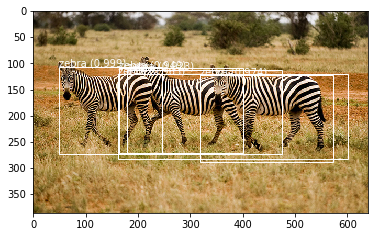

In [294]:
showresults('/content/drive/My Drive/DPprojects/Object Detection - Yolo/images/zebra.jpg')

horse 0.9981356 status: kept
horse 0.992822 status: removed
horse 0.9498803 status: removed
horse 0.8879715 status: removed
horse 0.7980072 status: removed
horse 0.7887686 status: removed
horse 0.63090116 status: removed
horse 0.9981356


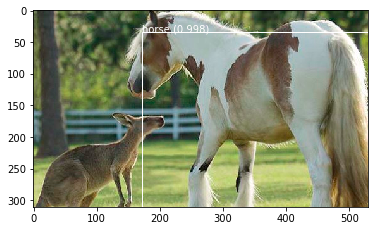

In [296]:
showresults('/content/drive/My Drive/DPprojects/Object Detection - Yolo/images/kangaroo.png')